In [51]:
FILE_NAME = "4-27-tr24-sway-bar/farthest_trial/rc_4.csv"

In [52]:
import pandas as pd

df = pd.read_csv(FILE_NAME)

In [53]:
STEERING_ANGLE_COLUMN = 'Analog1|"V"|0.0|5.0|25'
TIME_COLUMN = 'Interval|"ms"|0|0|1'
REAR_AXLE_COLUMN =  'RPM2|"rpm"|0|8000|200'
YAW_COLUMN = 'Yaw|"Deg/Sec"|-120|120|200'
LAT_ACC_COLUMN = 'AccelY|"G"|-3.0|3.0|200'
TIRE_RADIUS = 0.2921 # meters
TIRE_CIRCUMFERENCE = 2*TIRE_RADIUS * 3.14159 # meters


In [54]:

steering_angle = (df[STEERING_ANGLE_COLUMN] * (60.0/2.5)) - 60 # converting volts to degrees.
# It should be 0 volts = 60 degrees left
# 5 volts = 60 degrees right
times = df[TIME_COLUMN]

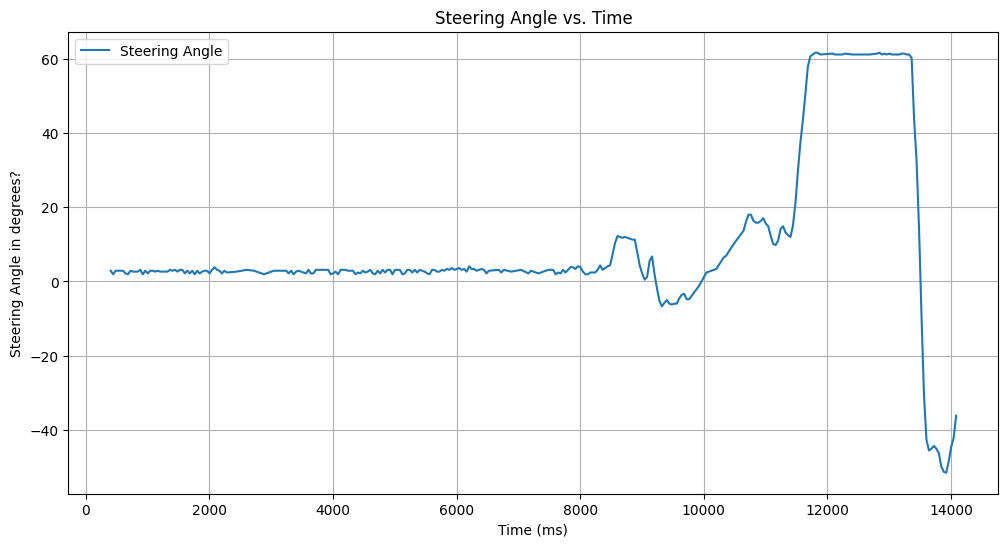

In [55]:
import matplotlib.pyplot as plt

valid_mask = ~steering_angle.isna()

plt.figure(figsize=(12, 6))
plt.plot(times[valid_mask], steering_angle[valid_mask], label='Steering Angle')
plt.xlabel('Time (ms)')
plt.ylabel('Steering Angle in degrees?')
plt.title('Steering Angle vs. Time')
plt.legend()
plt.grid()
plt.show()


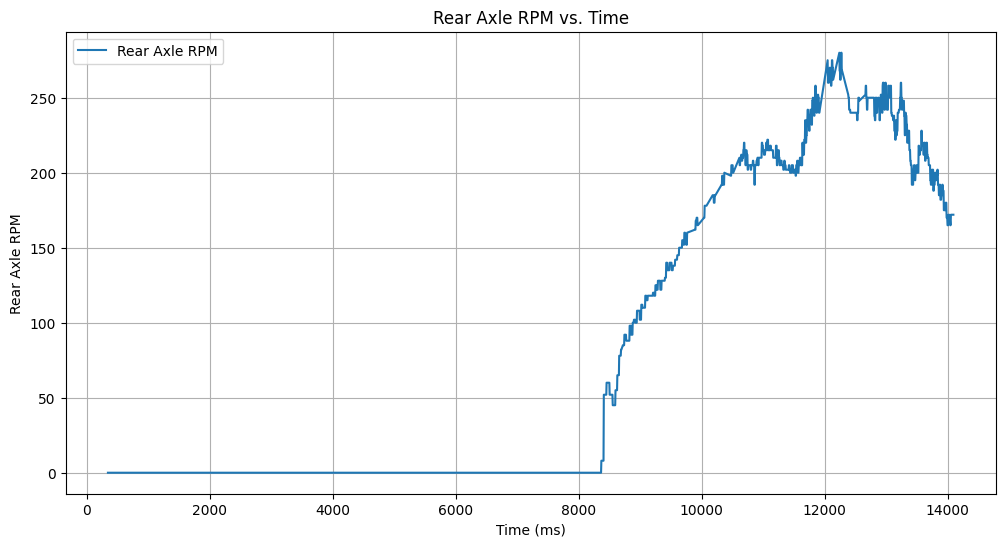

In [56]:
import matplotlib.pyplot as plt

valid_mask = ~df[REAR_AXLE_COLUMN].isna()

plt.figure(figsize=(12, 6))
plt.plot(times[valid_mask], df[REAR_AXLE_COLUMN][valid_mask], label='Rear Axle RPM')
plt.xlabel('Time (ms)')
plt.ylabel('Rear Axle RPM')
plt.title('Rear Axle RPM vs. Time')
plt.legend()
plt.grid()
plt.show()


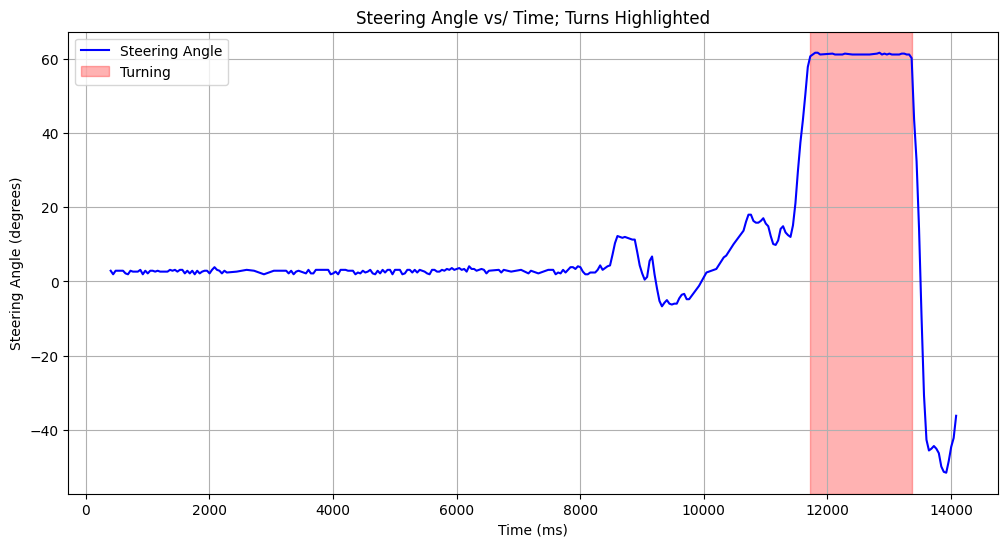

Detected turning interval (clean):
Start Index: 11723, End Index: 13363; End angle: 60.239999999999995


In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Remove NaNs
valid_mask = ~steering_angle.isna()
valid_indices = np.where(valid_mask)[0]  # Mapping from clean to original
times_clean = times[valid_mask].reset_index(drop=True)
steering_angle_clean = steering_angle[valid_mask].reset_index(drop=True)

# Settings
STEERING_THRESHOLD = 58   # degrees threshold

# Compute steering change per second
dt = np.diff(times_clean)              
dsteer = np.diff(steering_angle_clean)  
steer_rate = dsteer / dt                

# Detect conditions
is_turning = np.abs(steering_angle_clean) > STEERING_THRESHOLD

# Find intervals
def find_intervals(mask):
    intervals = []
    in_interval = False
    start_index = None

    for i, val in enumerate(mask):
        if val and not in_interval:
            start_index = i
            in_interval = True
        elif not val and in_interval:
            end_index = i - 1
            intervals.append((start_index, end_index))
            in_interval = False

    if in_interval:
        intervals.append((start_index, len(mask)-1))
    
    return intervals

turning_intervals_clean = find_intervals(is_turning)

# Map intervals back to original indices
turning_intervals_original = [(valid_indices[start], valid_indices[end]) for (start, end) in turning_intervals_clean]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(times_clean, steering_angle_clean, label='Steering Angle', color='blue')

# Highlight turning regions
for start_idx, end_idx in turning_intervals_clean:
    plt.axvspan(times_clean[start_idx], times_clean[end_idx], color='red', alpha=0.3, label='Turning' if start_idx == turning_intervals_clean[0][0] else "")

plt.xlabel('Time (ms)')
plt.ylabel('Steering Angle (degrees)')
plt.title('Steering Angle vs/ Time; Turns Highlighted')
plt.legend()
plt.grid()
plt.show()

# Print intervals
print("Detected turning interval (clean):")
for start, end in turning_intervals_clean:
    print(f"Start Index: {times_clean[start]}, End Index: {times_clean[end]}; End angle: {steering_angle_clean[end]}")


In [58]:
def get_turning_radius(turning_interval, rear_axle, steering_angle, yaw, wheel_circumference):
    start, end = turning_interval
    mrpm = np.mean(rear_axle[start:end])
    myaw = np.mean(yaw[start:end])
    #mangle = np.mean(steering_angle[start:end])
    mangle = 60 # we know we're at full lock
    velocity = wheel_circumference * mrpm * np.cos(np.radians(mangle)) / 60.0
    radius = velocity / myaw
    return radius

radius = get_turning_radius(
    turning_interval=turning_intervals_original[0],
    rear_axle=df[REAR_AXLE_COLUMN],
    steering_angle=steering_angle_clean,
    yaw=np.deg2rad(df[YAW_COLUMN]),
    wheel_circumference=TIRE_CIRCUMFERENCE
)

print(f"MY RADIUS LOOK HERE: {radius} meters or {radius * 3.28084} feet")

MY RADIUS LOOK HERE: 2.073839615782339 meters or 6.803935965043329 feet
